#### NCSU GIS 714: Geospatial Computation and Simulations

## Surface Water Simulation: Surface water flow and erosion simulation

In this assignment we explore simulation of spatial pattern of overland flow depth 
by running the SIMWE model which employs path sampling method to solve the shallow water flow equations.
We also compute sediment transport and net erosion and deposition using the
path sampling model.

Contents:
1. Overland Flow, Depth and Discharge
2. Overland Flow with Preferential Stream Flow Direction
3. Overland Flow with spatially-varible Mannings and Land Cover
4. Sediment Flow Rate, Erosion and Deposition

Additional Resources:
* [GRASS GIS Overview and Manual](https://grass.osgeo.org/grass-stable/manuals/index.html)
* [GRASS book](http://www.grassbook.org/)
* For more practice in watershed analysis see [Flow and watershed analysis in GIS582](http://ncsu-geoforall-lab.github.io/geospatial-modeling-course/grass/hydrology.html)

### Start GRASS GIS

In [2]:
# import subprocess
import sys
sys.path.append('/Applications/GRASS-8.4.app/Contents/Resources/etc/python')

# Import GRASS packages
import grass.script as gs
import grass.jupyter as gj

# Start GRASS Session
gj.init("/Users/asumi/grassdata", "nc_spm_08_grass7", "PERMANENT")

# Make a new mapset for this assignment
gs.run_command("g.mapset", mapset="HW3_B_water_simulation", location="nc_spm_08_grass7", flags="c")

### 1. Overland flow depth and discharge

Set the computational region to a small agricultural watershed and define the 2m resolution:

In [3]:
gs.run_command("g.region", region="rural_1m", res=2, flags="p")

projection: 99 (Lambert Conformal Conic)
zone:       0
datum:      nad83
ellipsoid:  a=6378137 es=0.006694380022900787
north:      220750
south:      220000
west:       638300
east:       639000
nsres:      2
ewres:      2
rows:       375
cols:       350
cells:      131250


Interpolate the elevation surface and compute its partial derivatives using spline function implemented in _[v.surf.rst](https://grass.osgeo.org/grass80/manuals/v.surf.rst.html)_.

In [9]:
gs.run_command("v.surf.rst",
               input="elev_lid792_bepts",
               elevation="elev_lid792_2m", 
               slope="dx_2m",
               aspect="dy_2m",
               tension=15,
               smooth=1.5,
               npmin=150,
               flags="d")

Note that partial derivatives can be also computed using _[r.slope.aspect](https://grass.osgeo.org/grass74/manuals/r.slope.aspect.html)_.

#### *Question 1*

Why do we need to compute elevation surface gradient vector for flow simulation? What does it control?

`## Answer`
- We assume that slope of surface is the same as elevation surface slope
- It controls the speed of the flow at each point of the raster map

Now, we compute spatial pattern of overland flow depth and discharge by running the SIMWE model implemented in the _[r.sim.water](https://grass.osgeo.org/grass80/manuals/r.sim.water.html)_ module - read the manual page to understand the parameters. We first use uniform rainfall excess, infiltration and land cover. This may take a minute to run.

In [10]:
# Output time step increment
increment = 2

gs.run_command("r.sim.water",
               elevation="elev_lid792_2m",
               dx="dx_2m",
               dy="dy_2m", 
               rain_value=50,
               infil_value=0,
               man_value=0.05,
               depth="wdp_2m",
               discharge="disch_2m",
               nwalkers=100000,
               niterations=30,
               output_step=increment,
               flags="t")

Display the results: 

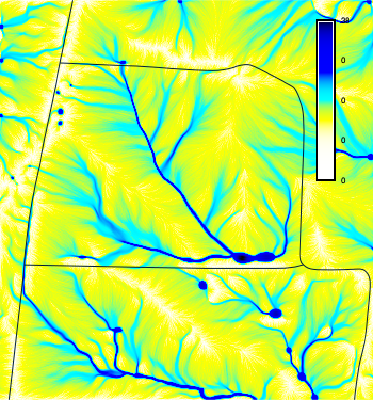

In [5]:
img = gj.Map(use_region=True)
img.d_rast(map="disch_2m.30") # Discharge at time=30
img.d_vect(map="streets_wake") # Roads
img.d_legend(raster="disch_2m.30", at=(55, 95, 85, 90), flags="l")
# Display map
img.show()

In [6]:
gs.run_command(
    "t.create",
    output="wdp_2m",
    type="strds",
    temporaltype="relative",
    semantictype="sum",
    title="Water Depth",
    description="Water Depth from r.sim.water",
)

wdp_list = gs.read_command(
    "g.list", type="raster", pattern="wdp_2m*", separator="comma"
).strip()

gs.run_command(
    "t.register",
    input="wdp_2m",
    type="raster",
    start=0,
    increment=increment,
    unit="minute",
    maps=wdp_list,
    flags="i",
)

In [7]:
water_depth = gj.TimeSeriesMap(use_region=True)
water_depth.add_raster_series("wdp_2m")
water_depth.d_vect(map="streets_wake")
water_depth.d_legend()
water_depth.show()

#### *Question 2*
Comment on the resulting pattern - where is the water ponding and what is causing it at this location? Is this realistic?

`#### Your Answer Here`
- There are ponding areas where the streams converge right before getting into the roads. There would be culverts underneath the roads and the water ponds there.


### 2. Peak runoff with preferential flow direction in the stream channel

To prevent ponding in a depression along the stream channel, we can add a preferential flow direction along the stream. This would, for example, correct for a stream flowing through a culvert under the road. In this section, we give all the cells in the stream a slope of 2 degrees and downstream flow direction.

Let's view the streams.

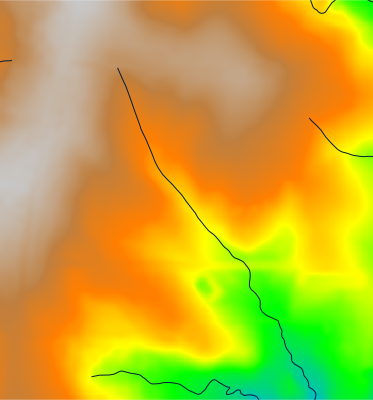

In [8]:
img = gj.Map(use_region=True)
img.d_rast(map="elev_lid792_2m")
img.d_vect(map="streams@PERMANENT")
# Display map
img.show()

First, we convert the stream vector to a raster so we can compute the stream's gradient. Using `v.to.rast`'s `use=dir ` method, we assign each cell value to the stream's direction (i.e. the direction the stream is flowing in).  

In [9]:
gs.run_command("v.to.rast", input="streams@PERMANENT", output="streams_dir_2m", use="dir")

Then, we convert the downstream direction to gradient by including a slope angle of 2 degrees. We use the formula:

$ \frac{\delta z}{\delta x} = \tan(\beta)*\cos(\alpha) $

$ \frac{\delta z}{\delta y} = \tan(\beta)*\sin(\alpha) $

Where $\beta$ is the slope and $\alpha$ is the stream direction.

#### *Question 3*

Modify the code below  so it executes the gradient formula above.

In [10]:
#### Your Answer Here
# Compute stream dx and dy using the stream direction angle and a slope angle equal to 2 degrees:
# Hint: trig operations take degree input (NOT radians)
gs.mapcalc("dx_stream = tan(2)*cos(streams_dir_2m)")
gs.mapcalc("dy_stream = tan(2)*sin(streams_dir_2m)")

Now, we can combine our preferential flow direction with the gradient rasters computed from the DEM and re-run SIMWE.

In [11]:
#Compute flow gradient vector by combining dx and dy derived from the DEM and stream:
gs.mapcalc("dx_dem_str = if(isnull(dx_stream), dx_2m, dx_stream)")
gs.mapcalc("dy_dem_str = if(isnull(dy_stream), dy_2m, dy_stream)")

#Run the overland flow model:
gs.run_command("r.sim.water",
                elevation="elev_lid792_2m",
                dx="dx_dem_str",
                dy="dy_dem_str",
                rain_value=50,
                infil_value=0,
                man_value=0.05,
                depth="wdpstr_2m",
                discharge="dischstr_2m",
                nwalkers=100000,
                niterations=30,
                output_step=2,
                flags="t"
                )

#### *Question 4*

Using one instance of `InteractiveMap` OR two instances of `Map`, visually compare the discharge from original overland flow simulation (`disch_2m.30`) to the simulation with preferential stream flow (`dischstr_2m.30`). In the perferential stream flow simulation, what happens at the road crossings now?

-> The flow is crossing the road!

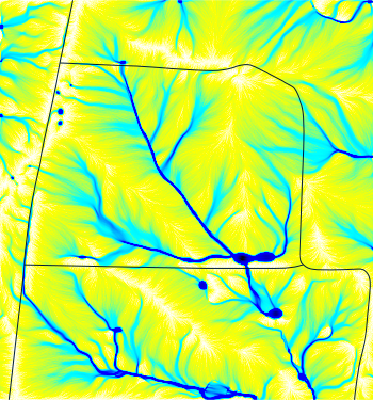

In [13]:
#### Your Answer Here
img = gj.Map(use_region=True)
# img.d_rast(map="disch_2m.30")
img.d_rast(map="dischstr_2m.30") # with correction
img.d_vect(map="streets_wake")
img.show()

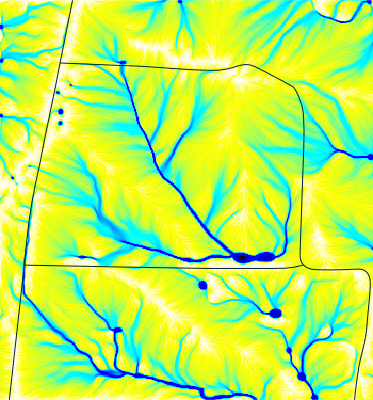

In [14]:
#### Your Answer Here
img = gj.Map(use_region=True)
img.d_rast(map="disch_2m.30") 
# img.d_rast(map="dischstr_2m.30") # with correction
img.d_vect(map="streets_wake")
img.show()

In [13]:
m = gj.InteractiveMap(use_region=True)
m.add_raster("streets_wake")
m.add_raster("disch_2m.30")
m.add_raster("dischstr_2m.30")
m.add_layer_control(position = "bottomright")
m.show()

ERROR: Required parameter <input> not set


CalledModuleError: Module run `r.proj input= output= mapset= project=nc_spm_08_grass7 dbase=/Users/asumi/grassdata resolution=2.47552308` ended with an error.
The subprocess ended with a non-zero return code: 1. See errors above the traceback or in the error output.

### 3. Runoff for spatially variable landcover and rainfall excess

We can continue to improve the model above by accounting for spatially varying landcover and rainfall. In this section, we compute runoff for spatially variable landcover (represented by spatially variable Mannings coefficient) and rainfall excess (rainfall intensity - infiltration rate).


We will use variable Mannings coefficient defined by reclassifying land cover class. Find out the land use categories in the map landcover_1m:

In [20]:
print(gs.read_command("r.category", map="landcover_1m"))

1	pond
2	forest
3	developed
4	bare
5	paved road
6	dirt road
7	vineyard
8	agriculture
9	wetland
10	bare ground path
11	grass



Let's also render a map of landcover and an ortho image of the area:

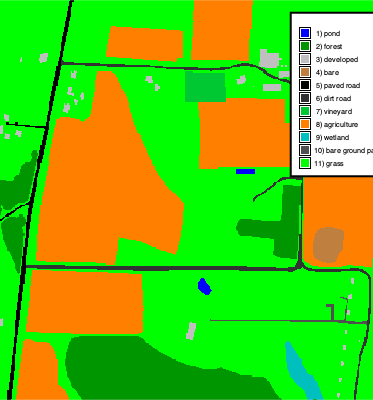

In [21]:
# Create Map instance
img = gj.Map(use_region=True)
img.d_rast(map="landcover_1m")
img.d_legend(raster="landcover_1m", at=(55, 95, 80, 84), flags="b")
# Display map
img.show()   

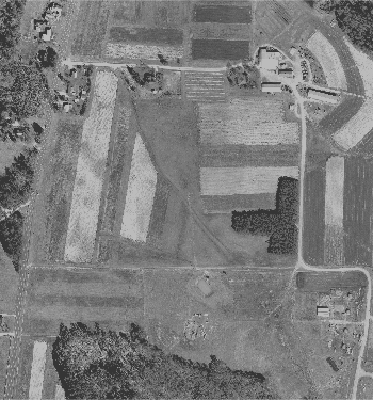

In [22]:
img = gj.Map(use_region=True)
img.d_rast(map="ortho_2001_t792_1m")
img.show()   

Next, we assign each category a Mannings roughness coefficient (published in literature) by recoding the landcover map using the _[r.recode](https://grass.osgeo.org/grass74/manuals/r.recode.html)_ module and reclassification rules stored in 
[`land_to_mannings.txt`](./land_to_mannings.txt):

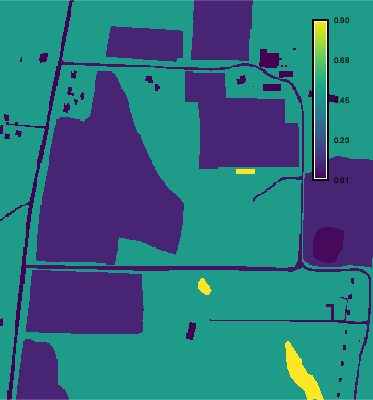

In [23]:
gs.run_command("r.recode", input="landcover_1m", output="mancover_2m", rules="land_to_mannings.txt")
img = gj.Map(use_region=True)
img.d_rast(map="mancover_2m")
img.d_legend(raster="mancover_2m", at=(55, 95, 84, 88))
# Display map
img.show()

Similarly, we will create raster with spatially variable rainfall excess rates based on the land cover classes. We use [`land_to_rain.txt`](./land_to_rain.txt) to specify the rates for individual classes. Again, we use the file as rules for the _[r.recode](https://grass.osgeo.org/grass74/manuals/r.recode.html)_ module.

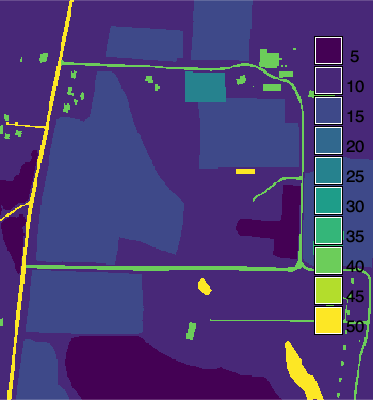

In [24]:
gs.run_command("r.recode", input="landcover_1m", output="raincover_2m", rules="land_to_rain.txt")
img = gj.Map(use_region=True)
img.d_rast(map="raincover_2m")
img.d_legend(raster="raincover_2m", at=(10, 95, 84, 88), thin=5)
# Display map
img.show()

#### *Question 5*

Run `r.sim.water` again but with spatially variable mannings and rain fall (see  _[GRASS Manual Page for r.sim.water](https://grass.osgeo.org/grass80/manuals/r.sim.water.html)_). Use the perferential stream flow gradient as input.

In [19]:
#### Your Answer Here
gs.mapcalc("dx_stream = tan(2)*cos(elev_lid792_2m)")
gs.mapcalc("dy_stream = tan(2)*sin(elev_lid792_2m)")

gs.mapcalc("dx_dem_str = if(isnull(dx_stream), dx_2m, dx_stream)")
gs.mapcalc("dy_dem_str = if(isnull(dy_stream), dy_2m, dy_stream)")

gs.run_command("r.sim.water",
                elevation="elev_lid792_2m",
                dx="dx_dem_str",
                dy="dy_dem_str",
                rain_value=50,
                infil_value=0,
                man_value=0.05,
                depth="wdpstrcov_2m",
                discharge="distrcov_2m",
                nwalkers=100000,
                niterations=30,
                output_step=2,
                flags="t",
                man="mancover_2m",
                rain="raincover_2m"
                )

#### *Question 6*
Visualize and comment on the resulting pattern - how is the flow depth related to the landcover? Which landcover holds most water?

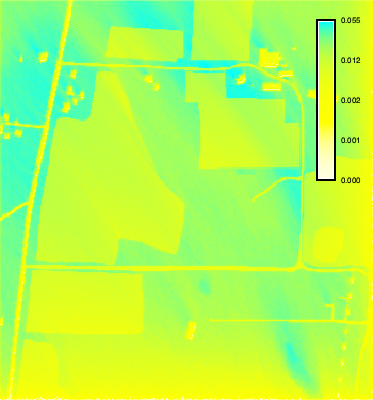

In [22]:
#### Your Answer Here
img = gj.Map(use_region=True)
img.d_rast(map="wdpstrcov_2m.30")
img.d_legend(raster="wdpstrcov_2m.30", at=(55, 95, 85, 90), flags="l")
img.show()

`#### Your Answer Here`


The grass areas have deeper flow while the agircultural lands did not hold the water. This could be considered because the grass areas are more previous compared to the agiricultural lands. 

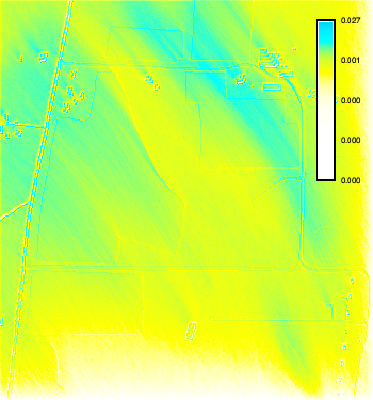

In [23]:
img = gj.Map(use_region=True)
img.d_rast(map="distrcov_2m.30")
img.d_legend(raster="distrcov_2m.30", at=(55, 95, 85, 90), flags="l")
img.show()

### 4. Sediment flow rate, erosion and deposition

Compute sediment flow rate and net erosion/deposition using sediment
transport part of the SIMWE model implemented in the
the _[r.sim.sediment](https://grass.osgeo.org/grass74/manuals/r.sim.sediment.html)_ module.
To make the computations faster, set region just to the upper part of
the watershed:

In [4]:
gs.run_command("g.region", s="s+290")

Compute input transport capacity and detachment coefficient maps:

In [5]:
gs.mapcalc("tranin = 0.001")
gs.mapcalc("detin = 0.001")

Compute input critical shear stress:

In [6]:
gs.mapcalc("tauin = 0.01")

Run the model using the last depth from previous run:

In [7]:
gs.run_command("g.copy", rast="wdp_2m.30,wdp_2m")
gs.run_command("r.sim.sediment",
               elevation="elev_lid792_2m",
               dx="dx_2m",
               dy="dy_2m",
               water_depth="wdp_2m",
               detachment_coeff="detin",
               transport_coeff="tranin",
               shear_stress="tauin",
               man_value=0.05,
               nwalkers=1000000,
               niterations=30,
               transport_capacity="tcapacity",
               tlimit_erosion_deposition="erdepmax",
               sediment_flux="sedflow",
               erosion_deposition="erdepsimwe")

Display the results:

In [8]:
# Create Interactive Map
fig = gj.InteractiveMap(use_region=True)
# Add raster, vector and layer control to map
fig.add_raster("tcapacity", opacity=1.0) # transport capacity
fig.add_raster("erdepmax", opacity=1.0) # transport limited erosion-deposition
fig.add_raster("sedflow", opacity=1.0) # sediment flux
fig.add_raster("erdepsimwe", opacity=1.0) #erosion and deposition
fig.add_layer_control(position = "bottomright")
# Display map
fig.show()

Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

#### *Question 7*

Describe the results shown on the map. What is shown in each of the layers?

`#### Your Answer Here.`


The layer `tcapacity` describes the transport capacity raster map [kg/ms]. This layer shows the stream has a significantly higher transport capacity than other areas. The layer `erdepmax` describes transport limited erosion-deposition raster map [kg/m2s] while the layer `erdepsimwe` shows erosion-deposition raster map [kg/m2s]. There are slight differences between these two layers shown in the map, diplaying the distribution of transport limited erosion-deposition. Lastly, the layer `sedflow` shows sediment flux raster map [kg/ms]. From this layer, you can see the sediments flux are low in the roads and high in the streams. 

### Additional Information
* [Website](https://github.com/ncsu-geoforall-lab/geospatial-simulations-course)
    
* [Computing Help](https://help.ncsu.edu/)
    
* [GIST Home](https://geospatial.ncsu.edu/)
    
* [Disclaimer](https://www.ncsu.edu/policies/prr-disclaimer.php)
    
* [Accessibility](https://oit.ncsu.edu/itaccess)

* License: 2018 [CC BY-SA](https://creativecommons.org/licenses/by-sa/4.0/)
  
* [NCSU GeoForAll Lab](https://geospatial.ncsu.edu/geoforall/)